# PM10 and Weather data gathering (All BE stations - BE: 79)

### Plain txt file to dataframe

Background-rural both for Ozone (O3 - Max daily 8-hour mean *max8h* ozone concentrations) is being read from disk as a CSV file (Older database: https://www.eea.europa.eu/data-and-maps/data/airbase-the-european-air-quality-database-8) for the stations in Belgium: "BExxxxx0001xxx"

In [78]:
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import timedelta
from numpy import genfromtxt

dirpath = "AirBase_BE_v8/PM10Belgium"
fnames = listdir(dirpath)  # Read all files in directory
stationLabels = ['PM10_'] * len(fnames)  # Suffix for Ozone label
for i in range(len(fnames)):
    stationLabels[i] += fnames[i][:7]  # Add the first area code name


In [79]:
# Read last data, 2013-2019
ts_last = pd.read_pickle("../../EAAAData/BE_AQeReporting_2013-2018/PM10/ts_daymean.pkl")

# No timezoneinfo
ts_last = ts_last.tz_convert(None)

# Normalized datetime index, removing the hour
ts_last.index = ts_last.index.normalize()

for column in ts_last.columns:
    if column != "PM10":
        if column not in stationLabels:
            stationLabels.append(column)

# TODO: add -1 lag
# previous_columns = ts_last.columns
# for column in previous_columns:
#     print("column", column)
#     ts_last[column + "-1"] = ts_last[column].shift()

ts_last.tail()

,PM10,PM10_BETN035,PM10_BETR740,PM10_BETR710,PM10_BETR020,PM10_BETB011,PM10_BETR834,PM10_BELRL01,PM10_BETR223,PM10_BETR501,...,PM10_BETR811,PM10_BELGK06,PM10_BELAL01,PM10_BETM204,PM10_BETN052,PM10_BETR803,PM10_BETR817,PM10_BETR805,PM10_BELRB01,PM10_BETR823
2019-01-21,NaN,37.970833,44.275000,44.325000,41.012500,29.578947,37.741667,43.137500,32.104500,28.667000,...,47.241667,43.408333,44.533333,28.375333,45.887500,NaN,NaN,NaN,NaN,NaN
2019-01-22,NaN,41.970833,35.941667,36.491667,39.158333,27.369565,35.700000,32.137500,31.687833,26.911565,...,40.491667,42.262500,40.054167,30.021167,34.387500,NaN,NaN,NaN,NaN,NaN
2019-01-23,NaN,48.495455,53.483333,53.137500,48.366667,36.979167,44.220833,48.220833,41.979500,36.833667,...,48.950000,50.908333,47.345833,37.854500,51.970833,NaN,NaN,NaN,NaN,NaN
2019-01-24,NaN,36.616667,47.462500,48.845833,40.095833,29.895833,38.970833,43.804167,22.854500,22.250333,...,47.116667,37.533333,45.825000,19.021167,43.554167,NaN,NaN,NaN,NaN,NaN
2019-01-25,NaN,23.271429,24.207692,23.000000,23.366667,12.733333,23.066667,17.914286,12.399143,12.434857,...,27.735714,24.623077,25.000000,5.577714,21.128571,NaN,NaN,NaN,NaN,NaN


In [80]:
columnLabels = ['PARCS','CI','RSN','SST','ISTL1','ISTL2','ISTL3','ISTL4',  # Attach all the ECMWF weather labels
                 'SWVL1','SWVL2','SWVL3','SWVL4','10FG','LSPF','CAPE','SP','W','STL1','SD','LSP','CP','SF','SSHF','MSL','BLH',
                 'TCC','10U','V','2T','2D','SSRD','STL2','STRD','SSR','TTR','E','STL3','LCC','MCC','HCC','SRC','MX2T','MN2T',
                 'RO','TCO3','TP','IEWS','SKT','STL4','FAL','FSR']
columnLabels = stationLabels + columnLabels  # Join lists
for i in range(len(fnames)):
    columnLabels.append(stationLabels[i] + "-1")  # Append the lag-1 day values

In [81]:
ts_last["PM10_BETR740"].tail()

2019-01-21    44.275000
2019-01-22    35.941667
2019-01-23    53.483333
2019-01-24    47.462500
2019-01-25    24.207692
Freq: D, Name: PM10_BETR740, dtype: float64

In [82]:
list(ts_last.columns)

['PM10',
 'PM10_BETN035',
 'PM10_BETR740',
 'PM10_BETR710',
 'PM10_BETR020',
 'PM10_BETB011',
 'PM10_BETR834',
 'PM10_BELRL01',
 'PM10_BETR223',
 'PM10_BETR501',
 'PM10_BETR815',
 'PM10_BETR221',
 'PM10_BETN043',
 'PM10_BELSZ02',
 'PM10_BETN121',
 'PM10_BETM802',
 'PM10_BETR502',
 'PM10_BETR510',
 'PM10_BELAB02',
 'PM10_BETN067',
 'PM10_BETM705',
 'PM10_BETN093',
 'PM10_BETN045',
 'PM10_BETR750',
 'PM10_BETR802',
 'PM10_BELAL02',
 'PM10_BETR511',
 'PM10_BETMEU1',
 'PM10_BETR702',
 'PM10_BETR512',
 'PM10_BETN073',
 'PM10_BETN054',
 'PM10_BETR012',
 'PM10_BETWOL1',
 'PM10_BETR731',
 'PM10_BELOB02',
 'PM10_BETN132',
 'PM10_BETR001',
 'PM10_BETR701',
 'PM10_BELAL05',
 'PM10_BETR240',
 'PM10_BETN085',
 'PM10_BETN070',
 'PM10_BETN100',
 'PM10_BETH201',
 'PM10_BETR222',
 'PM10_BETN113',
 'PM10_BETR831',
 'PM10_BELMN01',
 'PM10_BELHB23',
 'PM10_BETN016',
 'PM10_BELSA04',
 'PM10_BETN012',
 'PM10_BETN060',
 'PM10_BETN063',
 'PM10_BELOB01',
 'PM10_BETN029',
 'PM10_BETR841',
 'PM10_BETR801',
 'PM1

In [83]:
for stationLabel in stationLabels:
    if stationLabel.startswith("PM10_BETN"):
        print(stationLabel)

PM10_BETN043
PM10_BETN045
PM10_BETN052
PM10_BETN054
PM10_BETN060
PM10_BETN063
PM10_BETN066
PM10_BETN067
PM10_BETN070
PM10_BETN073
PM10_BETN085
PM10_BETN093
PM10_BETN100
PM10_BETN113
PM10_BETN121
PM10_BETN132
PM10_BETN035
PM10_BETN016
PM10_BETN012
PM10_BETN029


In [84]:
# 1 loop to instantiate minDate & maxDate
for i in range(0, 1):
    fname = fnames[i]
    dfColumn = stationLabels[i]
    columnNames = ['month']
    for i in range(1,32):  # First column is sensor reading, second is validity of day (1 == OK, 0, -1 = NOT OK)
        columnNames.append(str(i))
        columnNames.append('validity{}'.format(i))
    df1 = pd.read_csv(dirpath + "/" + fname, sep='\t', names=columnNames, lineterminator='\n')
    df1['month'] = pd.to_datetime(df1['month'])
    currentMinDate = min(df1['month'])
    currentMaxDate = max(df1['month']) + timedelta(days=30) # Add 30 days to December 1st   
minDate = currentMinDate
maxDate = currentMaxDate

# Now, do search all files for minDate, MaxDate
for i in range(0, len(fnames)):
    fname = fnames[i]
    dfColumn = stationLabels[i]
    columnNames = ['month']
    for i in range(1,32):  # First column is sensor reading, second is validity of day (1 == OK, 0, -1 = NOT OK)
        columnNames.append(str(i))
        columnNames.append('validity{}'.format(i))

    df1 = pd.read_csv(dirpath + "/" + fname, sep='\t', names=columnNames, lineterminator='\n')
    df1['month'] = pd.to_datetime(df1['month'])

    currentMinDate = min(df1['month'])
    currentMaxDate = max(df1['month']) + timedelta(days=30) # Add 30 days to December 1st
    
    if currentMinDate < minDate:
        minDate = currentMinDate
    if currentMaxDate > maxDate:
        maxDate = currentMaxDate       
        
# Finally, to check the last data        
minDate2013_2018 = ts_last.index.min()
maxDate2013_2018 = ts_last.index.max()
if minDate2013_2018 < minDate:
    minDate = minDate2013_2018
if maxDate2013_2018 > maxDate:
    maxDate = maxDate2013_2018     

print ("Min date: {}, Max Date: {}".format(minDate, maxDate))
ts = pd.DataFrame(np.nan, index=pd.date_range(start=minDate, end=maxDate, freq='D'), columns=columnLabels)

# Normalized datetime index, removing the hour
ts.index = ts.index.normalize()

Min date: 1995-01-01 00:00:00, Max Date: 2019-01-25 00:00:00


In [85]:
df1.head()

,month,1,validity1,2,validity2,3,validity3,4,validity4,5,...,27,validity27,28,validity28,29,validity29,30,validity30,31,validity31
0,2001-01-01,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,...,22.0,1,36.0,1,52.0,1,45.0,1,52.0,1
1,2001-02-01,74.0,1,27.0,1,18.0,1,13.0,1,17.0,...,32.0,1,25.0,1,0.0,0,0.0,0,0.0,0
2,2001-03-01,38.0,1,46.0,1,54.0,1,53.0,1,50.0,...,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0
3,2001-04-01,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,...,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0,0.0,0
4,2001-05-01,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,...,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0,-9999.0,0


In [86]:
for i in range(0, len(fnames)):
    fname = fnames[i]
    dfColumn = stationLabels[i]
    columnNames = ['month']
    for i in range(1,32):  # First column is sensor reading, second is validity of day (1 == OK, 0, -1 = NOT OK)
        columnNames.append(str(i))
        columnNames.append('validity{}'.format(i))

    df1 = pd.read_csv(dirpath + "/" + fname, sep='\t', names=columnNames, lineterminator='\n')
    df1['month'] = pd.to_datetime(df1['month'])

    minDate = min(df1['month'])
    maxDate = max(df1['month']) + timedelta(days=30) # Add 30 days to December 1st

    for row in df1.itertuples(index=True, name='df1'): # Foreach month
        date = row[1]
        for columnIndex in range(1, df1.shape[1]): # Foreach day
            if columnIndex % 2 == 0: # Even column
                if row[columnIndex + 1] == 1: # If sensor reading valid
                    currentDate = date + timedelta(days=((columnIndex - 2) / 2)) # Get year-month-day
                    try:
                        ts.at[currentDate, dfColumn] = row[columnIndex] # Set value to time-series
                    except AttributeError as error:
                        print("fname: ", fname)
                        print("Error: ", error)
                        break

columnLabels               

['PM10_BE0312A',
 'PM10_BEGRT01',
 'PM10_BELAB01',
 'PM10_BELAB02',
 'PM10_BELAL01',
 'PM10_BELAL02',
 'PM10_BELAL05',
 'PM10_BELGK06',
 'PM10_BELGK09',
 'PM10_BELHB23',
 'PM10_BELHR01',
 'PM10_BELKO01',
 'PM10_BELML01',
 'PM10_BELMN01',
 'PM10_BELOB01',
 'PM10_BELOB02',
 'PM10_BELRL01',
 'PM10_BELSA04',
 'PM10_BELSZ02',
 'PM10_BELTR01',
 'PM10_BELWZ01',
 'PM10_BELZD01',
 'PM10_BETAND3',
 'PM10_BETB011',
 'PM10_BETH201',
 'PM10_BETM204',
 'PM10_BETM705',
 'PM10_BETM802',
 'PM10_BETMEU1',
 'PM10_BETN043',
 'PM10_BETN045',
 'PM10_BETN052',
 'PM10_BETN054',
 'PM10_BETN060',
 'PM10_BETN063',
 'PM10_BETN066',
 'PM10_BETN067',
 'PM10_BETN070',
 'PM10_BETN073',
 'PM10_BETN085',
 'PM10_BETN093',
 'PM10_BETN100',
 'PM10_BETN113',
 'PM10_BETN121',
 'PM10_BETN132',
 'PM10_BETR001',
 'PM10_BETR012',
 'PM10_BETR020',
 'PM10_BETR201',
 'PM10_BETR221',
 'PM10_BETR222',
 'PM10_BETR223',
 'PM10_BETR240',
 'PM10_BETR501',
 'PM10_BETR502',
 'PM10_BETR510',
 'PM10_BETR511',
 'PM10_BETR512',
 'PM10_BETR701

In [87]:
print("Station count: ", len(stationLabels))

Station count:  83


In [88]:
stationLabels

['PM10_BE0312A',
 'PM10_BEGRT01',
 'PM10_BELAB01',
 'PM10_BELAB02',
 'PM10_BELAL01',
 'PM10_BELAL02',
 'PM10_BELAL05',
 'PM10_BELGK06',
 'PM10_BELGK09',
 'PM10_BELHB23',
 'PM10_BELHR01',
 'PM10_BELKO01',
 'PM10_BELML01',
 'PM10_BELMN01',
 'PM10_BELOB01',
 'PM10_BELOB02',
 'PM10_BELRL01',
 'PM10_BELSA04',
 'PM10_BELSZ02',
 'PM10_BELTR01',
 'PM10_BELWZ01',
 'PM10_BELZD01',
 'PM10_BETAND3',
 'PM10_BETB011',
 'PM10_BETH201',
 'PM10_BETM204',
 'PM10_BETM705',
 'PM10_BETM802',
 'PM10_BETMEU1',
 'PM10_BETN043',
 'PM10_BETN045',
 'PM10_BETN052',
 'PM10_BETN054',
 'PM10_BETN060',
 'PM10_BETN063',
 'PM10_BETN066',
 'PM10_BETN067',
 'PM10_BETN070',
 'PM10_BETN073',
 'PM10_BETN085',
 'PM10_BETN093',
 'PM10_BETN100',
 'PM10_BETN113',
 'PM10_BETN121',
 'PM10_BETN132',
 'PM10_BETR001',
 'PM10_BETR012',
 'PM10_BETR020',
 'PM10_BETR201',
 'PM10_BETR221',
 'PM10_BETR222',
 'PM10_BETR223',
 'PM10_BETR240',
 'PM10_BETR501',
 'PM10_BETR502',
 'PM10_BETR510',
 'PM10_BETR511',
 'PM10_BETR512',
 'PM10_BETR701

In [89]:
ts_bak = ts
ts_last_bak = ts_last

In [90]:
ts = ts_bak
ts_last = ts_last_bak

In [91]:
#ts = ts.append(ts_last, sort=True)# TODO: test merge
# ts = pd.concat([ts, ts_last], ignore_index=False, sort=True)
#ts = ts.merge(ts_last, how="right", validate="one_to_one")
#ts = ts.merge(ts_last, how="right")
#ts = ts.merge(ts_last, how="outer", validate="one_to_many")
#ts = ts.merge(ts_last, how="outer", sort=True)
# ts = ts.update(ts_last)
# ts = pd.merge_ordered(ts, ts_last)
#ts = ts.combine_first(ts_last)
#ts = ts_last.combine_first(ts)
#ts = ts.update(ts_last)
#ts = pd.concat(ts, ts_last, axis=1, join_axes=[ts.index])

ts.columns

Index(['PM10_BE0312A', 'PM10_BEGRT01', 'PM10_BELAB01', 'PM10_BELAB02',
       'PM10_BELAL01', 'PM10_BELAL02', 'PM10_BELAL05', 'PM10_BELGK06',
       'PM10_BELGK09', 'PM10_BELHB23',
       ...
       'PM10_BETR801-1', 'PM10_BETR802-1', 'PM10_BETR811-1', 'PM10_BETR815-1',
       'PM10_BETR831-1', 'PM10_BETR832-1', 'PM10_BETR833-1', 'PM10_BETR834-1',
       'PM10_BETR841-1', 'PM10_BETWOL1-1'],
      dtype='object', length=207)

In [92]:
ts_last.columns

Index(['PM10', 'PM10_BETN035', 'PM10_BETR740', 'PM10_BETR710', 'PM10_BETR020',
       'PM10_BETB011', 'PM10_BETR834', 'PM10_BELRL01', 'PM10_BETR223',
       'PM10_BETR501', 'PM10_BETR815', 'PM10_BETR221', 'PM10_BETN043',
       'PM10_BELSZ02', 'PM10_BETN121', 'PM10_BETM802', 'PM10_BETR502',
       'PM10_BETR510', 'PM10_BELAB02', 'PM10_BETN067', 'PM10_BETM705',
       'PM10_BETN093', 'PM10_BETN045', 'PM10_BETR750', 'PM10_BETR802',
       'PM10_BELAL02', 'PM10_BETR511', 'PM10_BETMEU1', 'PM10_BETR702',
       'PM10_BETR512', 'PM10_BETN073', 'PM10_BETN054', 'PM10_BETR012',
       'PM10_BETWOL1', 'PM10_BETR731', 'PM10_BELOB02', 'PM10_BETN132',
       'PM10_BETR001', 'PM10_BETR701', 'PM10_BELAL05', 'PM10_BETR240',
       'PM10_BETN085', 'PM10_BETN070', 'PM10_BETN100', 'PM10_BETH201',
       'PM10_BETR222', 'PM10_BETN113', 'PM10_BETR831', 'PM10_BELMN01',
       'PM10_BELHB23', 'PM10_BETN016', 'PM10_BELSA04', 'PM10_BETN012',
       'PM10_BETN060', 'PM10_BETN063', 'PM10_BELOB01', 'PM10_BETN029'

In [93]:
# Normalized datetime index, removing the hour
# ts.index = ts.index.normalize()
# ts_last.index = ts_last.index.normalize()

# TODO: create missing columns
for column in ts_last.columns:
    if column != "PM10":
#         print("column:", column)
        if column not in ts.columns:
            print("column:", column)
            print("Added column:", column)
            ts[column] = np.nan

In [94]:
# Add the ts values 2013-2018

lst1 = list(ts.columns)
lst2 = list(ts_last.columns)

# Copy values
for row in ts_last.itertuples(index=True, name='ts_last'): # Foreach month
    date = row[0]
    for i in range(len(row) - 1):
        column = lst2[i]
        if column != "PM10" and "PM10_" in column:
#             print("column", column)
#             print(date)
#             print("lst1.index(column)", lst1.index(column) + 1)
#             print("lst2.index(column)", lst2.index(column) + 1)
#             print("row[lst2.index(column)]", row[lst2.index(column) + 1])
#             ts.at[date, lst1.index(column) + 1] = row[lst2.index(column) + 1]
            value = row[lst2.index(column)]
            if value != np.nan and value != None:
                ts.at[date, column] = value
            #ts.at[row[0], 'O3_' + row[stationNameIndex]] = row[valueIndex] # Set value to time-series

In [95]:
lst1.index('PM10_BE0312A')
#ts['PM10_BE0312A'] = np.nan

0

In [96]:
lst1[0]

'PM10_BE0312A'

In [97]:
ts.columns[0]

'PM10_BE0312A'

In [98]:
ts["PM10_BETR702"]["2016-9-2"]

9.3125

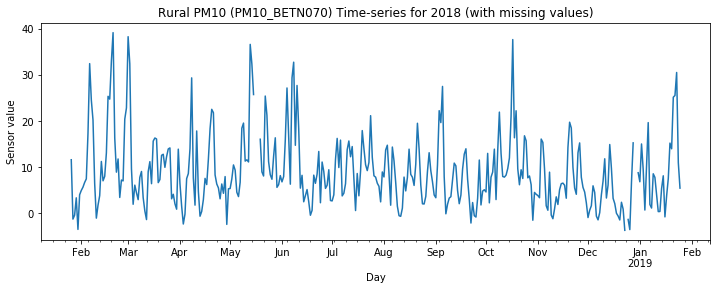

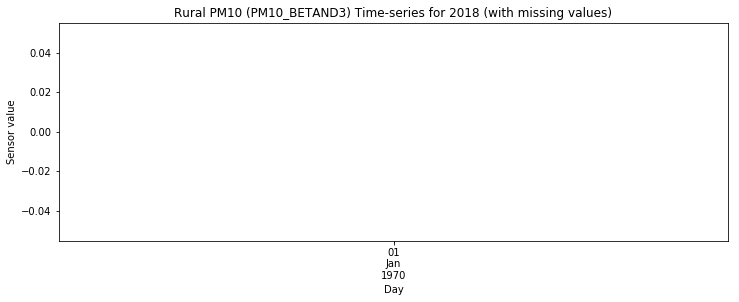

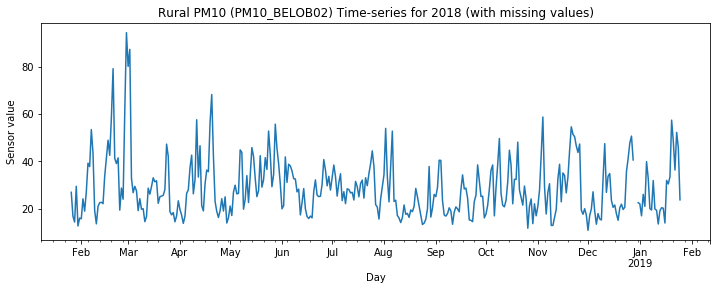

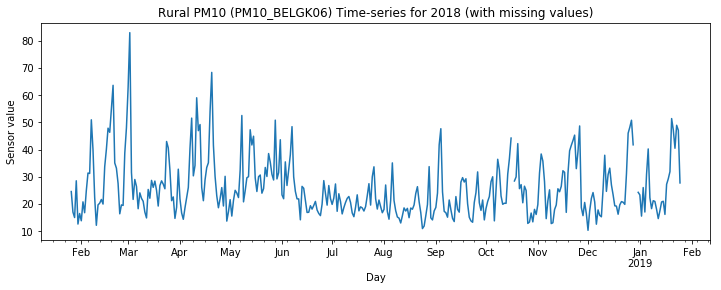

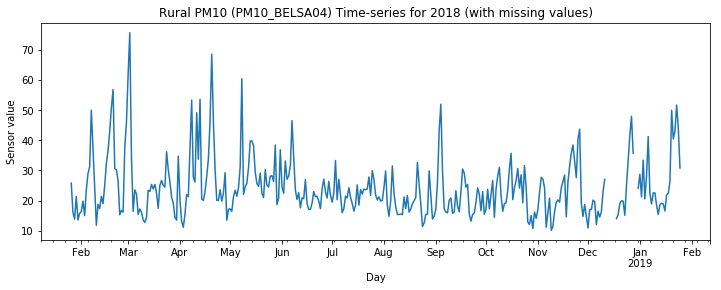

In [99]:
# Test plot stations
stationsToCheck = ['PM10_BETN070', 'PM10_BETAND3', 'PM10_BELOB02', 'PM10_BELGK06','PM10_BELSA04']
for stationToCheck in stationsToCheck:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Rural PM10 ({}) Time-series for 2018 (with missing values)'.format(stationToCheck))
    ax.grid(True)
    ts.tail(365)[stationToCheck].plot(ax = ax);

### On missing values get the reading from the closest station

Get the correlation between different stations (columns):

In [100]:
import math
from collections import OrderedDict

def getCorrelation(station1, station2):
    return ts[station1].corr(ts[station2])

correlationStationToStation = {}

for station1 in ts.columns:
    if "PM10_" in station1 and "-1" not in station1:
        correlationsToStation = {}
        for station2 in ts.columns:
            if station1 != station2 and "PM10_" in station2 and "-1" not in station2: 
                correlation = getCorrelation(station1, station2)  
                if correlation != None and not np.isnan(correlation):
                    correlationsToStation[station2] = correlation
        correlationStationToStation[station1] = OrderedDict(sorted(correlationsToStation.items(), reverse=True, key=lambda t: t[1]))

C:\Users\temp3rr0r\Anaconda3\envs\tensorflowLast\lib\site-packages\numpy\lib\function_base.py:2392: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\temp3rr0r\Anaconda3\envs\tensorflowLast\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [101]:
correlationStationToStation["PM10_BELOB02"].keys()

odict_keys(['PM10_BETR823', 'PM10_BETR817', 'PM10_BETR805', 'PM10_BELRB01', 'PM10_BETR803', 'PM10_BETR020', 'PM10_BETR833', 'PM10_BELRL01', 'PM10_BETN016', 'PM10_BELGK06', 'PM10_BETR512', 'PM10_BETR811', 'PM10_BETR223', 'PM10_BETR221', 'PM10_BETR710', 'PM10_BELAL02', 'PM10_BETN093', 'PM10_BETN029', 'PM10_BETM204', 'PM10_BETN012', 'PM10_BETN132', 'PM10_BETR502', 'PM10_BETB011', 'PM10_BETN060', 'PM10_BETR801', 'PM10_BETR834', 'PM10_BELMN01', 'PM10_BETR802', 'PM10_BETR841', 'PM10_BETR701', 'PM10_BELSA04', 'PM10_BETR740', 'PM10_BETR702', 'PM10_BETN067', 'PM10_BELAL01', 'PM10_BELSZ02', 'PM10_BELHB23', 'PM10_BETR731', 'PM10_BETWOL1', 'PM10_BETR750', 'PM10_BETN063', 'PM10_BETR012', 'PM10_BELAB02', 'PM10_BETR240', 'PM10_BETR815', 'PM10_BETR510', 'PM10_BETN054', 'PM10_BETN100', 'PM10_BETR501', 'PM10_BETN113', 'PM10_BETR511', 'PM10_BETR222', 'PM10_BETN052', 'PM10_BETMEU1', 'PM10_BELOB01', 'PM10_BETN073', 'PM10_BETN043', 'PM10_BETN121', 'PM10_BELAB01', 'PM10_BETN085', 'PM10_BETN045', 'PM10_BELAL0

In [102]:
getCorrelation("PM10_BELOB02", "PM10_BETR710")

0.8742881983146786

In [103]:
correlationStationToStation["PM10_BETN073"].keys()

odict_keys(['PM10_BELWZ01', 'PM10_BELGK09', 'PM10_BETR510', 'PM10_BETR501', 'PM10_BETR511', 'PM10_BELML01', 'PM10_BETN067', 'PM10_BETR201', 'PM10_BETN063', 'PM10_BETB011', 'PM10_BETN054', 'PM10_BEGRT01', 'PM10_BELAL01', 'PM10_BETR221', 'PM10_BETR502', 'PM10_BETR832', 'PM10_BETR222', 'PM10_BETM204', 'PM10_BELSZ02', 'PM10_BETN100', 'PM10_BETR012', 'PM10_BELGK06', 'PM10_BELAB01', 'PM10_BELAB02', 'PM10_BETR823', 'PM10_BETN113', 'PM10_BETR815', 'PM10_BETR512', 'PM10_BETR702', 'PM10_BELRL01', 'PM10_BETR223', 'PM10_BETR817', 'PM10_BELRB01', 'PM10_BETR801', 'PM10_BETR811', 'PM10_BETR803', 'PM10_BETWOL1', 'PM10_BETR805', 'PM10_BELMN01', 'PM10_BETN045', 'PM10_BETMEU1', 'PM10_BETN052', 'PM10_BETN016', 'PM10_BETR710', 'PM10_BETR834', 'PM10_BELSA04', 'PM10_BETR020', 'PM10_BETR701', 'PM10_BELOB02', 'PM10_BETN093', 'PM10_BETR750', 'PM10_BETR841', 'PM10_BETN029', 'PM10_BETR833', 'PM10_BETN012', 'PM10_BELHB23', 'PM10_BETR731', 'PM10_BELAL02', 'PM10_BETH201', 'PM10_BETN121', 'PM10_BETR740', 'PM10_BETN13

In [104]:
correlationStationToStation["PM10_BETN073"]

OrderedDict([('PM10_BELWZ01', 0.9106295254086606),
             ('PM10_BELGK09', 0.8678323444713336),
             ('PM10_BETR510', 0.8649834787802798),
             ('PM10_BETR501', 0.838054659439997),
             ('PM10_BETR511', 0.8366747969771329),
             ('PM10_BELML01', 0.8266361040546417),
             ('PM10_BETN067', 0.8222363694167316),
             ('PM10_BETR201', 0.8221090728313274),
             ('PM10_BETN063', 0.8202175524271906),
             ('PM10_BETB011', 0.8166040711521322),
             ('PM10_BETN054', 0.8075588173913162),
             ('PM10_BEGRT01', 0.807470671416404),
             ('PM10_BELAL01', 0.806944860665837),
             ('PM10_BETR221', 0.8064523447612113),
             ('PM10_BETR502', 0.8046562991547811),
             ('PM10_BETR832', 0.8025094610830917),
             ('PM10_BETR222', 0.801023452606688),
             ('PM10_BETM204', 0.7966519555079234),
             ('PM10_BELSZ02', 0.7963289152546817),
             ('PM10_BETN100', 0.795

In [105]:
ts2 = ts.copy()
# TODO: Normalized datetime index, removing the hour
ts2.index = ts2.index.normalize()

for dataRow in ts2.itertuples(index=True, name='Pandas'):
    date = dataRow[0]
    for stationLabel in ts2.columns:       
        if "PM10_" in stationLabel and "-1" not in stationLabel:       
            try: # TODO: isnnan.any() for cells with dual values
                if np.isnan(ts2.at[date, stationLabel]):  # If no value at station
                    for closestStationLabel in correlationStationToStation[stationLabel].keys():                
                        closestValue = ts.at[date, closestStationLabel]
                        if not np.isnan(closestValue):
                            ts2.at[date, stationLabel] = closestValue
                            break  # Exit the loop    
            except (ValueError,IOError) as err:
                print("date: ", date, "stationLabel: ", stationLabel)
                print(err)
                
ts = ts2  

In [106]:
ts["PM10_BETR702"]["2016-09-2"]

9.3125

In [107]:
ts.head(365)["PM10_BELOB02"].head(20)

1995-01-01    19.0
1995-01-02    24.0
1995-01-03    98.0
1995-01-04    42.0
1995-01-05    45.0
1995-01-06    81.0
1995-01-07    93.0
1995-01-08    27.0
1995-01-09    56.0
1995-01-10    30.0
1995-01-11    27.0
1995-01-12    38.0
1995-01-13    69.0
1995-01-14    97.0
1995-01-15    49.0
1995-01-16    24.0
1995-01-17    26.0
1995-01-18    26.0
1995-01-19    19.0
1995-01-20    43.0
Freq: D, Name: PM10_BELOB02, dtype: float64

In [108]:
ts.tail(365)["PM10_BELOB02"].head(20)

2018-01-26    26.983333
2018-01-27    16.879167
2018-01-28    14.441667
2018-01-29    29.525000
2018-01-30    12.795833
2018-01-31    16.108333
2018-02-01    15.816667
2018-02-02    24.233333
2018-02-03    19.025000
2018-02-04    27.182609
2018-02-05    39.275000
2018-02-06    37.837500
2018-02-07    53.462500
2018-02-08    43.441667
2018-02-09    19.295833
2018-02-10    13.670833
2018-02-11    21.025000
2018-02-12    22.608333
2018-02-13    22.775000
2018-02-14    22.191667
Freq: D, Name: PM10_BELOB02, dtype: float64

Check if missing values indeed filled:

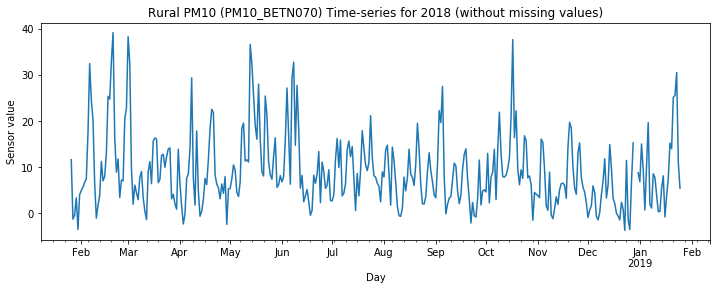

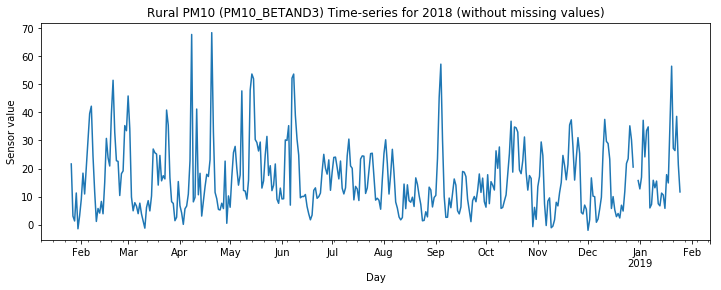

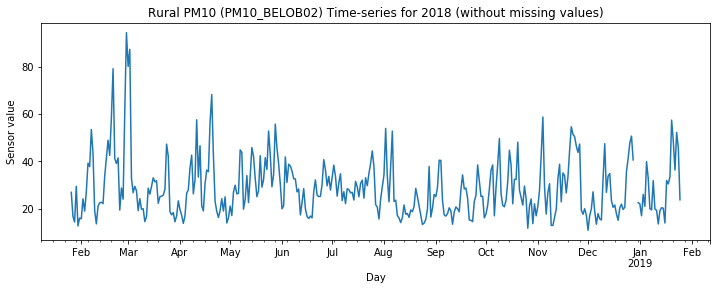

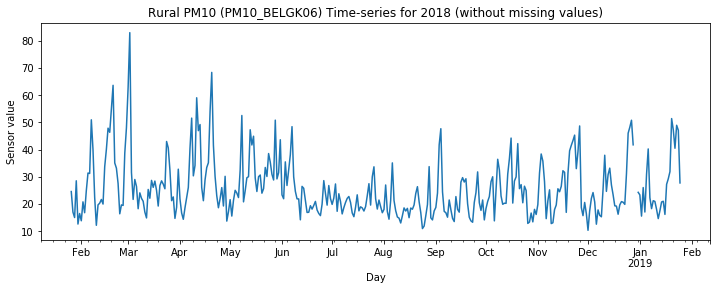

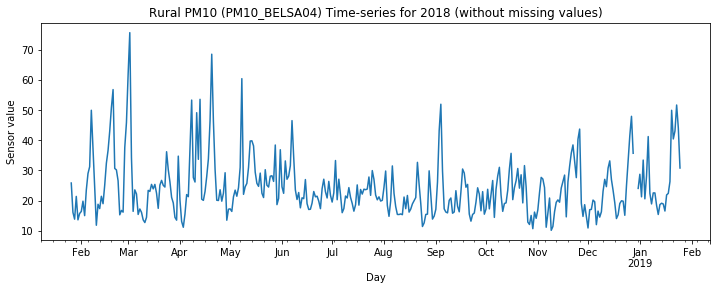

In [109]:
# Test plot stations
for stationToCheck in stationsToCheck:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Rural PM10 ({}) Time-series for 2018 (without missing values)'.format(stationToCheck))
    ax.grid(True)
    ts.tail(365)[stationToCheck].plot(ax = ax);

Adding weather data into the dataframe:

In [110]:
weatherDataColumns = ['PARCS','CI','RSN','SST','ISTL1','ISTL2','ISTL3','ISTL4',  # Attach all the ECMWF weather labels
                 'SWVL1','SWVL2','SWVL3','SWVL4','10FG','LSPF','CAPE','SP','W','STL1','SD','LSP','CP','SF','SSHF','MSL','BLH',
                 'TCC','10U','V','2T','2D','SSRD','STL2','STRD','SSR','TTR','E','STL3','LCC','MCC','HCC','SRC','MX2T','MN2T',
                 'RO','TCO3','TP','IEWS','SKT','STL4','FAL','FSR']
weatherDataNew = genfromtxt('ECMWF\BETN073_51vars_19900101To20181231.csv', delimiter=',')
minWeatherDate = "01-01-1990"
maxWeatherDate = "31-12-2018"
weather_ts = pd.DataFrame(weatherDataNew, index=pd.date_range(start=minWeatherDate, end=maxWeatherDate, freq='D'), columns=weatherDataColumns)

weather_ts.index = weather_ts.index.normalize() # Normalized datetime index, removing the hour

print(weather_ts.shape, weatherDataNew.shape)

(10592, 51) (10592, 51)


In [111]:
weather_ts.head()

,PARCS,CI,RSN,SST,ISTL1,ISTL2,ISTL3,ISTL4,SWVL1,SWVL2,...,MX2T,MN2T,RO,TCO3,TP,IEWS,SKT,STL4,FAL,FSR
1990-01-01,444553.3125,0.0,99.999985,273.352539,271.459824,271.459839,271.459854,271.459961,0.298347,0.299438,...,275.128418,274.782593,0.000045,0.005519,0.0,-0.020990,274.543457,282.382812,0.189940,0.191961
1990-01-02,450023.5625,0.0,99.999985,273.351562,271.460388,271.460434,271.459976,271.459961,0.297440,0.298363,...,277.109863,276.395264,0.000046,0.005992,0.0,-0.002058,276.202881,282.292175,0.189814,0.191961
1990-01-03,453719.4375,0.0,99.999985,273.350586,271.460007,271.460312,271.460175,271.459961,0.296425,0.297562,...,275.929443,275.655884,0.000047,0.007510,0.0,-0.184821,275.471191,282.198242,0.189696,0.191964
1990-01-04,457172.3750,0.0,99.999985,273.350830,271.459717,271.459656,271.460220,271.459961,0.295204,0.296326,...,275.460815,274.836182,0.000048,0.006678,0.0,0.105883,274.214111,282.104309,0.189574,0.146393
1990-01-05,461869.8750,0.0,99.999985,273.351562,271.459808,271.460114,271.460175,271.459961,0.295425,0.296227,...,278.035156,277.420288,0.000048,0.006242,0.0,0.028112,276.170654,282.006409,0.189452,0.191962


In [112]:
weather_ts.tail()

,PARCS,CI,RSN,SST,ISTL1,ISTL2,ISTL3,ISTL4,SWVL1,SWVL2,...,MX2T,MN2T,RO,TCO3,TP,IEWS,SKT,STL4,FAL,FSR
2018-12-27,414830.6250,0.0,99.999985,275.198730,271.459656,271.460007,271.460220,271.459961,0.233154,0.234200,...,277.234741,276.372559,0.000014,0.006669,0.000001,0.009318,276.572266,283.189819,0.161208,0.113639
2018-12-28,414884.9375,0.0,99.999985,275.067871,271.460251,271.459564,271.460114,271.459961,0.231964,0.232590,...,278.856689,278.332764,0.000015,0.006754,0.000083,0.045983,277.466797,282.989136,0.161116,0.127085
2018-12-29,419315.0625,0.0,99.999985,275.070312,271.459839,271.460159,271.460175,271.459961,0.232742,0.232025,...,281.661865,280.991211,0.000015,0.006992,0.000301,0.534758,280.926758,282.913940,0.161013,0.181972
2018-12-30,420687.8750,0.0,99.999985,275.152588,271.459610,271.460220,271.459824,271.459961,0.231911,0.231865,...,280.683838,279.797607,0.000016,0.006464,0.000254,0.152843,280.461426,282.917175,0.160918,0.181867
2018-12-31,431265.4375,0.0,99.999985,275.113525,271.459930,271.460220,271.459991,271.459961,0.232346,0.232468,...,282.099854,281.288086,0.000016,0.005841,0.000043,0.077620,280.570679,282.806213,0.160815,0.181866


In [113]:
weather_ts.index[0]

Timestamp('1990-01-01 00:00:00', freq='D')

In [114]:
ts.index[0]

Timestamp('1995-01-01 00:00:00', freq='D')

In [115]:
# Attach weather data
ts3 = ts.copy()

for dataRow in weather_ts.itertuples(index=True, name='weather_ts'):  # days from 1-1-1990 -> 1-1-1995
    date = dataRow[0]
    if date >= ts3.index[0]:  # After 1995, else throws exception
        for weatherVariableLabel in weather_ts.columns:    
            try:
                valuets3 = ts3.at[date, weatherVariableLabel]
                if np.isnan(valuets3):
                    weatherValue = weather_ts.at[date, weatherVariableLabel]
                    if not np.isnan(weatherValue):
                        ts3.at[date, weatherVariableLabel] = weatherValue
            except (ValueError,IOError) as err:
                print("EXCEPTION: date: ", date, "weatherVariableLabel: ", weatherVariableLabel)
                print(err)

ts = ts3

In [116]:
# Remove 2019 from TS
ts = ts["1995-01-01":"2018-12-31"]

In [117]:
ts.tail(365)["PM10_BELOB02"].head(20)

2018-01-01    17.420833
2018-01-02    21.108333
2018-01-03    23.066667
2018-01-04    19.175000
2018-01-05    23.754167
2018-01-06    20.045833
2018-01-07    24.754167
2018-01-08    41.400000
2018-01-09    30.545833
2018-01-10    38.045833
2018-01-11    53.170833
2018-01-12    45.525000
2018-01-13    41.337500
2018-01-14    24.775000
2018-01-15    16.670833
2018-01-16    20.170833
2018-01-17    14.670833
2018-01-18    18.629167
2018-01-19    19.712500
2018-01-20    20.212500
Freq: D, Name: PM10_BELOB02, dtype: float64

In [118]:
ts["SST"].tail(10)

2018-12-22    275.188232
2018-12-23    275.229736
2018-12-24    275.209717
2018-12-25    275.186279
2018-12-26    275.211670
2018-12-27    275.198730
2018-12-28    275.067871
2018-12-29    275.070312
2018-12-30    275.152588
2018-12-31    275.113525
Freq: D, Name: SST, dtype: float64

In [119]:
ts.head()

,PM10_BE0312A,PM10_BEGRT01,PM10_BELAB01,PM10_BELAB02,PM10_BELAL01,PM10_BELAL02,PM10_BELAL05,PM10_BELGK06,PM10_BELGK09,PM10_BELHB23,...,PM10_BETR801-1,PM10_BETR802-1,PM10_BETR811-1,PM10_BETR815-1,PM10_BETR831-1,PM10_BETR832-1,PM10_BETR833-1,PM10_BETR834-1,PM10_BETR841-1,PM10_BETWOL1-1
1995-01-01,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-02,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-03,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-04,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-05,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
ts.tail()

,PM10_BE0312A,PM10_BEGRT01,PM10_BELAB01,PM10_BELAB02,PM10_BELAL01,PM10_BELAL02,PM10_BELAL05,PM10_BELGK06,PM10_BELGK09,PM10_BELHB23,...,PM10_BETR801-1,PM10_BETR802-1,PM10_BETR811-1,PM10_BETR815-1,PM10_BETR831-1,PM10_BETR832-1,PM10_BETR833-1,PM10_BETR834-1,PM10_BETR841-1,PM10_BETWOL1-1
2018-12-27,27.125333,40.000000,50.200000,33.458667,49.200000,50.200000,49.866667,50.804167,50.804167,54.845833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-28,20.514222,31.611111,39.200000,19.983176,36.500000,39.200000,41.166667,41.755556,41.755556,42.100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31,12.687833,17.000000,22.970833,15.187833,21.866667,22.970833,23.033333,24.283333,24.283333,21.387500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Add 1-day lags:

In [121]:
# TODO: add -1 lag
previous_columns = ts.columns
for column in previous_columns:
    if "PM10_" in column and "-1" not in column:
        ts[column + "-1"] = ts[column].shift()

C:\Users\temp3rr0r\Anaconda3\envs\tensorflowLast\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Add 7-day lags:

In [45]:
# TODO: Add up to -7 day lags
max_lag = 7

previous_columns = ts.columns
for column in previous_columns:
    
    if "PM10_" in column and ("-" + str(max_lag)) not in column and "-" not in column:
        
        ts_column_shifted = ts[column].shift()
        
        for lag in range(2, max_lag + 1):            
            ts_column_shifted = ts_column_shifted.shift()            
            ts[column + ("-" + str(lag))] = ts_column_shifted


C:\Users\temp3rr0r\Anaconda3\envs\tensorflowLast\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [122]:
ts.head(6000).tail(9)["PM10_BETN073"]

2011-05-28    13.071
2011-05-29     9.008
2011-05-30    22.592
2011-05-31    13.550
2011-06-01    15.071
2011-06-02    13.008
2011-06-03    18.758
2011-06-04    21.404
2011-06-05    21.862
Freq: D, Name: PM10_BETN073, dtype: float64

In [123]:
ts.head(6000).tail(9)["PM10_BETN073-1"]

2011-05-28    17.362
2011-05-29    13.071
2011-05-30     9.008
2011-05-31    22.592
2011-06-01    13.550
2011-06-02    15.071
2011-06-03    13.008
2011-06-04    18.758
2011-06-05    21.404
Freq: D, Name: PM10_BETN073-1, dtype: float64

In [124]:
ts.head(6000).tail(9)["PM10_BETN073-5"]

KeyError: 'PM10_BETN073-5'

In [125]:
ts.head(6000).tail(9)["PM10_BETN073-7"]

KeyError: 'PM10_BETN073-7'

In [126]:
ts.head(6000).tail(5)["PARCS"]

2011-06-01    2985829.0
2011-06-02    2989148.0
2011-06-03    2985147.0
2011-06-04    2988199.0
2011-06-05    2996629.0
Freq: D, Name: PARCS, dtype: float64

In [127]:
ts.head(6000).tail(5)["FSR"]

2011-06-01    0.146390
2011-06-02    0.146392
2011-06-03    0.146395
2011-06-04    0.146398
2011-06-05    0.146392
Freq: D, Name: FSR, dtype: float64

Time-series plot of O3, first 365 days (1990, with missing data):

KeyError: 'PM10_BETN070-7'

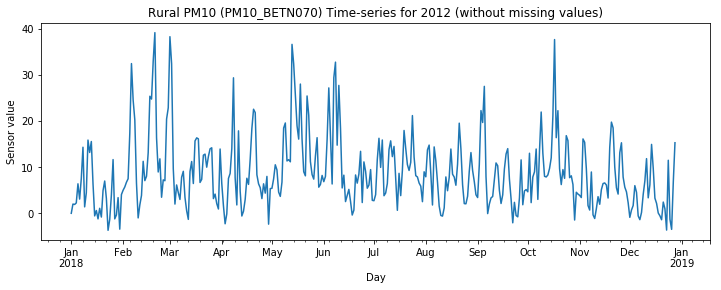

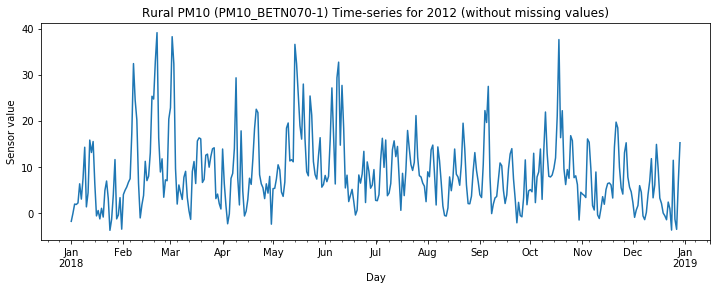

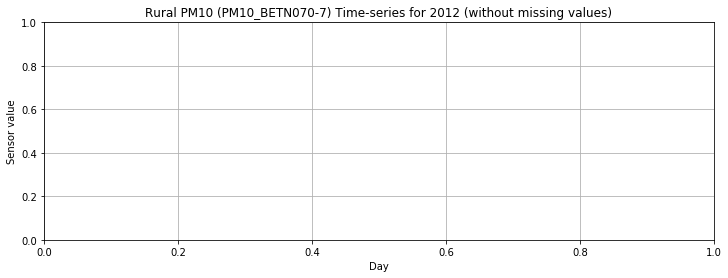

In [128]:
# Test plot stations and lags
for stationToCheck in stationsToCheck:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Rural PM10 ({}) Time-series for 2012 (without missing values)'.format(stationToCheck))
    ax.grid(True)
    ts.tail(365)[stationToCheck].plot(ax = ax);
    
    stationToCheckLag = stationToCheck + "-1"
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Rural PM10 ({}) Time-series for 2012 (without missing values)'.format(stationToCheckLag))
    ax.grid(True)
    ts.tail(365)[stationToCheckLag].plot(ax = ax);
    
    stationToCheckLag = stationToCheck + "-7"
        
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.set_ylabel('Sensor value')
    ax.set_xlabel('Day')
    ax.set_title('Rural PM10 ({}) Time-series for 2012 (without missing values)'.format(stationToCheckLag))
    ax.grid(True)
    ts.tail(365)[stationToCheckLag].plot(ax = ax);

Plot other time-series variables (Temperature 2m):

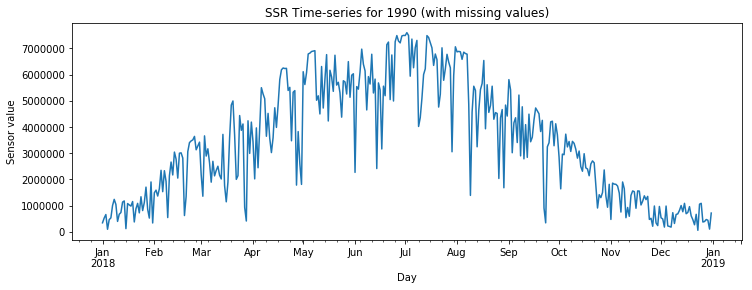

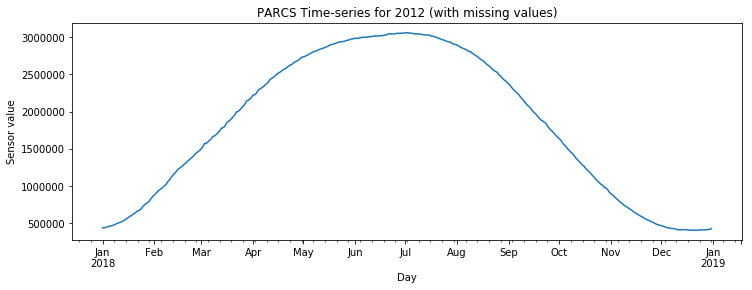

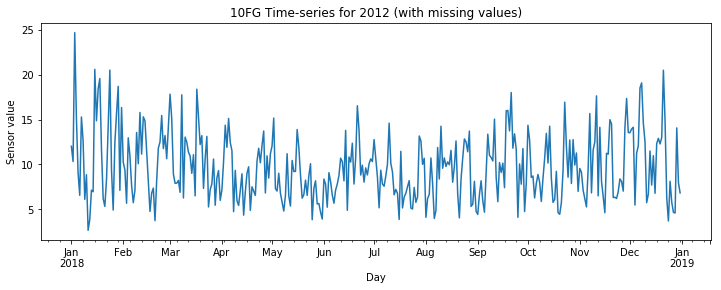

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('SSR Time-series for 1990 (with missing values)')
ax.grid(True)
# ts.tail(365)['2T'].plot(ax = ax);
# ['O3', '10FG', 'BLH', '10U', '2T', 'SSR', 'SUND', 'O3-1']
#['O3','PARCS','CI','RSN','SST','ISTL1','ISTL2','ISTL3','ISTL4','SWVL1','SWVL2','SWVL3','SWVL4','10FG','LSPF','CAPE','SP','W','STL1','SD','LSP','CP','SF','SSHF','MSL','BLH','TCC','10U','V','2T','2D','SSRD','STL2','STRD','SSR','TTR','E','STL3','LCC','MCC','HCC','SRC','MX2T','MN2T','RO','TCO3','TP','IEWS','SKT','STL4','FAL','FSR','O3-1']
ts.tail(365)['SSR'].plot(ax = ax);

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('PARCS Time-series for 2012 (with missing values)')
ax.grid(True)
ts.tail(365)['PARCS'].plot(ax = ax);

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('10FG Time-series for 2012 (with missing values)')
ax.grid(True)
ts.tail(365)['10FG'].plot(ax = ax);

Lag variable (-1 day):

In [130]:
ts.tail(10)[stationLabels[0]]  

2018-12-22     3.937833
2018-12-23    10.729500
2018-12-24    23.187833
2018-12-25    20.062833
2018-12-26    21.083667
2018-12-27    27.125333
2018-12-28    20.514222
2018-12-29          NaN
2018-12-30          NaN
2018-12-31    12.687833
Freq: D, Name: PM10_BE0312A, dtype: float64

In [131]:
ts.tail(10)[stationLabels[0] + '-1']

2018-12-22     5.979500
2018-12-23     3.937833
2018-12-24    10.729500
2018-12-25    23.187833
2018-12-26    20.062833
2018-12-27    21.083667
2018-12-28    27.125333
2018-12-29    20.514222
2018-12-30          NaN
2018-12-31          NaN
Freq: D, Name: PM10_BE0312A-1, dtype: float64

In [132]:
ts.tail(10)[stationLabels[1]]

2018-12-22    16.630435
2018-12-23    21.717391
2018-12-24    31.145833
2018-12-25    38.895833
2018-12-26    54.208333
2018-12-27    40.000000
2018-12-28    31.611111
2018-12-29          NaN
2018-12-30          NaN
2018-12-31    17.000000
Freq: D, Name: PM10_BEGRT01, dtype: float64

In [133]:
ts.tail(10)[stationLabels[1] + '-1']

2018-12-22    20.047619
2018-12-23    16.630435
2018-12-24    21.717391
2018-12-25    31.145833
2018-12-26    38.895833
2018-12-27    54.208333
2018-12-28    40.000000
2018-12-29    31.611111
2018-12-30          NaN
2018-12-31          NaN
Freq: D, Name: PM10_BEGRT01-1, dtype: float64

In [134]:
ts.tail(10)[stationLabels[2]]

2018-12-22    19.095833
2018-12-23    18.575000
2018-12-24    28.991667
2018-12-25    38.595833
2018-12-26    46.783333
2018-12-27    50.200000
2018-12-28    39.200000
2018-12-29          NaN
2018-12-30          NaN
2018-12-31    22.970833
Freq: D, Name: PM10_BELAB01, dtype: float64

In [135]:
ts.tail(10)[stationLabels[2] + '-1']

2018-12-22    20.470833
2018-12-23    19.095833
2018-12-24    18.575000
2018-12-25    28.991667
2018-12-26    38.595833
2018-12-27    46.783333
2018-12-28    50.200000
2018-12-29    39.200000
2018-12-30          NaN
2018-12-31          NaN
Freq: D, Name: PM10_BELAB01-1, dtype: float64

In [136]:
ts.tail(10)[stationLabels[3]]

2018-12-22     3.687833
2018-12-23    13.979500
2018-12-24    32.687833
2018-12-25    45.333667
2018-12-26    59.604500
2018-12-27    33.458667
2018-12-28    19.983176
2018-12-29          NaN
2018-12-30          NaN
2018-12-31    15.187833
Freq: D, Name: PM10_BELAB02, dtype: float64

In [137]:
ts.tail(10)[stationLabels[3] + '-1']

2018-12-22     6.208667
2018-12-23     3.687833
2018-12-24    13.979500
2018-12-25    32.687833
2018-12-26    45.333667
2018-12-27    59.604500
2018-12-28    33.458667
2018-12-29    19.983176
2018-12-30          NaN
2018-12-31          NaN
Freq: D, Name: PM10_BELAB02-1, dtype: float64

In [138]:
ts.isna().sum().sum()

20566

In [139]:
ts.shape

(8766, 217)

Not useful interpolations: Cubic and Spline (order 2-5+) seem to have very high leverage, skewing the original data:

Useful interpolations: 'from_derivatives' (piecewise polynomial interpolation) and linear. (Probably) the most interesting interpolation: PCHIP 1-d monotonic cubic interpolation (see:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PchipInterpolator.html#scipy.interpolate.PchipInterpolator). Compared to the plain cubic interpolation, doesn't seem to skew the original data points. Pchip looks similar to the linear interpolation, with some extra smoothing.

In [140]:
ts_interpolated = ts.interpolate(method='linear',limit=8,limit_direction='both')  # 8 days
ts_interpolated.head(10)['PM10_BETN066']

1995-01-01    19.0
1995-01-02    24.0
1995-01-03    98.0
1995-01-04    42.0
1995-01-05    45.0
1995-01-06    81.0
1995-01-07    93.0
1995-01-08    27.0
1995-01-09    56.0
1995-01-10    30.0
Freq: D, Name: PM10_BETN066, dtype: float64

In [141]:
print("Count of NaN values: ", np.isnan(ts_interpolated).any().sum())

Count of NaN values:  2


In [142]:
print("Count of zero values: ", ts_interpolated.size - np.count_nonzero(ts_interpolated))

Count of zero values:  58762


In [143]:
len(ts.columns)

217

In [144]:
ts_interpolated.isnull().sum().sum()

17532

In [145]:
ts_interpolated.isna().sum().sum()

17532

In [70]:
# Store to time-series csv
# file_name = "ALL_BE_51vars_PM10_PM10-1_19950101To20181231.csv"
file_name = "ALL_BE_51vars_PM10_PM10-7_19950101To20181231.csv"
ts_interpolated.to_csv(file_name, sep=',', encoding='utf-8')

#### Calendar data

Conversion of calendar data into cyclical features within [-1, 1].
Inspiration: http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

In [146]:
def getCyclicalFeature(column):
    return np.sin((column - column.min())*(2. * (np.pi / column.max()))), np.cos((column - column.min())*(2. * (np.pi / column.max())))

In [147]:
sinCyclicalMonth, cosCyclicalMonth = getCyclicalFeature(ts_interpolated.index.month)
sinCyclicalDayOfWeek, cosCyclicalDayOfWeek = getCyclicalFeature(ts_interpolated.index.dayofweek)
sinCyclicalDayOfYear, cosCyclicalDayOfYear = getCyclicalFeature(ts_interpolated.index.dayofyear)
sinCyclicalWeekOfYear, cosCyclicalWeekOfYear = getCyclicalFeature(ts_interpolated.index.weekofyear)

In [148]:
ts_interpolated['sin_cyclical_month'] = sinCyclicalMonth
ts_interpolated['cos_cyclical_month'] = cosCyclicalMonth
ts_interpolated['sin_cyclical_day_of_week'] = sinCyclicalDayOfWeek
ts_interpolated['cos_cyclical_day_of_week'] = cosCyclicalDayOfWeek
ts_interpolated['sin_cyclical_day_of_year'] = sinCyclicalDayOfYear
ts_interpolated['cos_cyclical_day_of_year'] = cosCyclicalDayOfYear
ts_interpolated['sin_cyclical_week_of_year'] = sinCyclicalWeekOfYear
ts_interpolated['cos_cyclical_week_of_year'] = cosCyclicalWeekOfYear

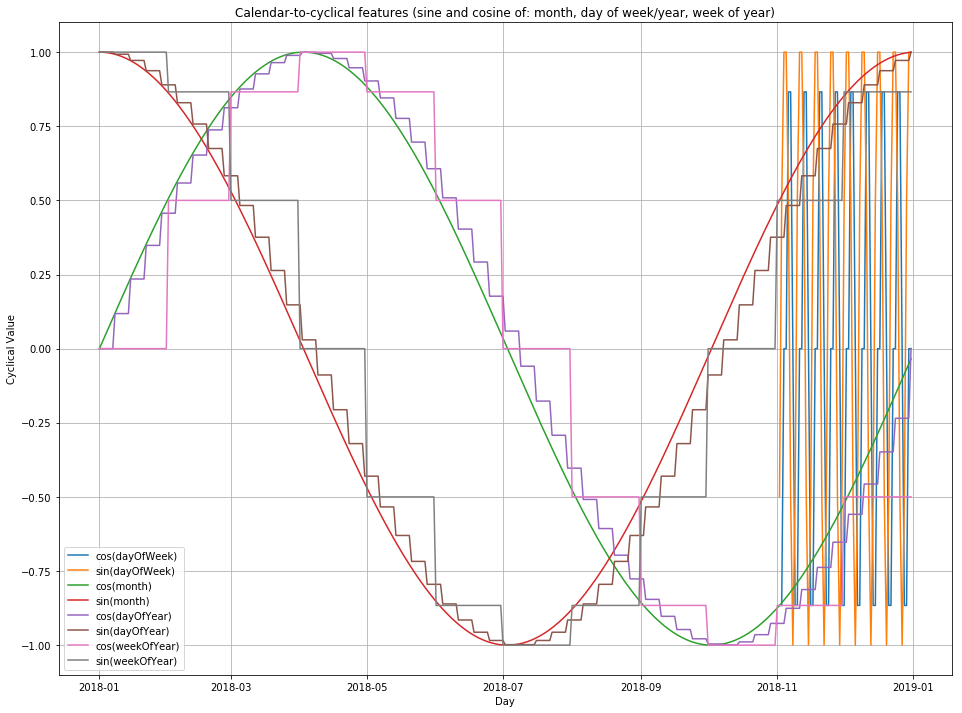

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.set_ylabel('Cyclical Value')
ax.set_xlabel('Day')
ax.set_title('Calendar-to-cyclical features (sine and cosine of: month, day of week/year, week of year)')
ax.grid(True)

ax.plot(ts_interpolated['sin_cyclical_day_of_week'].tail(60))
ax.plot(ts_interpolated['cos_cyclical_day_of_week'].tail(60))
ax.plot(ts_interpolated['sin_cyclical_day_of_year'].tail(365))
ax.plot(ts_interpolated['cos_cyclical_day_of_year'].tail(365))
ax.plot(ts_interpolated['sin_cyclical_week_of_year'].tail(365))
ax.plot(ts_interpolated['cos_cyclical_week_of_year'].tail(365))
ax.plot(ts_interpolated['sin_cyclical_month'].tail(365))
ax.plot(ts_interpolated['cos_cyclical_month'].tail(365))

ax.legend(['cos(dayOfWeek)', 'sin(dayOfWeek)', 'cos(month)', 'sin(month)', 'cos(dayOfYear)', 'sin(dayOfYear)', 'cos(weekOfYear)', 'sin(weekOfYear)'])

In [150]:
# Store to time-series csv
file_name = "ALL_BE_51vars_calendar_PM10_PM10-7_19950101To20181231.csv"
# file_name = "ALL_BE_51vars_calendar_PM10_PM10-1_19950101To20181231.csv"
ts_interpolated.to_csv(file_name, sep=',', encoding='utf-8')